## IMDB Review NLP

--- 

Neste notebook vamos ler um arquivo do tipo **.csv** com cerca de 50.000 reviews de diversos filmes do [IMDB](https://www.imdb.com/) disponíveis no [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) e analisar o sentimento de cada review, baseado em um segundo dataset também disponível no [Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp), que comporta uma coleção de frases simples acompanhadas do sentimento classificado como predominante nela (como tristeza, raiva, amor, medo, etc). 

O processo foi dividido em N etapas, sendo elas:

1. *Configuração de Ambiente*
   1. *Higienização de dados*
   2. *Métodos e Variáveis do ambiente*
2. *Leitura do Dataset de Reviews.*
   1. *Limpeza dos Diretórios*
   2. *Criação de arquivos de review*
   3. *Criação de Bag of Words*
3. *Leitura do Dataset de Sentimento.*
4. *Sumário dos dados obtidos após leitura dos Datasets.*
5. ... 

Durante a etapa N iremos mostrar uma análise dos sentimentos encontrados em cada review e falar um pouco sobre...


---

#### Passo 1 - Configuração de Ambiente

In [ ]:
%pip install -r requirements.txt

In [ ]:
import os
import pandas as pds
import seaborn as sns
import matplotlib as mpl
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud, ImageColorGenerator
from nltk import FreqDist, RegexpTokenizer
from nltk.corpus import brown, stopwords
from bs4 import BeautifulSoup


In [ ]:
# reads the csv using the pandas library
data_frame = pds.read_csv('../assets/Reviews/reviews.csv')
# defines a pattern to search inside the csv
pattern = r'(<br>|<br />|http)'
# replaces the pattern values with empty string
data_frame['review'] = data_frame['review'].str.replace(pattern, "", regex=True)

In [197]:
# Métodos Comuns

# Adquire e retorna a frequencias de palavras a partir de um 
# filepath e dicionario como parametros.
def get_top_words(data: dict, filepath: str):

    with open(filepath, 'r', encoding='utf-8') as file:
        review = file.read()

        tokenizer = RegexpTokenizer(r'\w+')
        words = tokenizer.tokenize(review)

        stop_words = stopwords.words('english')

        filtered_words = [item for item in words if item not in stop_words]
        
        for item in FreqDist(filtered_words).most_common():
            key = item[0]
            value = item[1]

            if key in data: data[key] += value
            else:  data[key] = value

        return data
    
# gera uma nuvem de palavras a partir da lista de frequencias
# e titulo do grafico fornecidos como parametro.
def get_word_cloud(title: str, limit: int, data: dict):
    cloud = WordCloud(
        max_words=limit,
        colormap='tab20c',
        stopwords=stopwords,
        collocations=True
    ).generate_from_frequencies(data)

    plt.figure(figsize=(10,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title, fontsize=12)
    plt.show() 

### Passo 2 - Leitura do Dataset de Reviews.
---

O objetivo deste passo é ler o CSV referente aos reviews do IMDB e verificar se o sentimento foi positivo ou negativo (lembrando que neste Dataset só existem esses dois sentimentos), em seguida vamos gerar um arquivo **.txt** no padrão *indíce_linha-sentimento.txt* e enviar para um diretório especifico com base no sentimento do review (positivo ou negativo).

Esse passo ocorre em 3 etapas:

1. Limpeza dos diretórios.
2. Criação de arquivos de review.
3. Criação de Bag of Words
4. Criação de Gráficos

---



#### Passo 2.1 - Limpeza dos Diretórios

In [ ]:
# Antes realizaremos a limpeza dos diretorios antes de começarmos a criar 
# os arquivos .txt
path_positivos = "../dist/reviews/positivos"
path_negativos = "../dist/reviews/negativos"

try:
	# primeiro nos certificamos de que os diretórios existem
	if(os.path.isdir(path_negativos)):
		# verificamos cada arquivo do dentro do diretorio
		for file in os.listdir(path_negativos):
			# ignoramos arquivos diferentes do tipo .txt
			if not file.endswith(".txt"):
				continue
			os.remove(os.path.join(path_negativos, file)) #removemos o arquivo
	
	# repetimos o processo para o path_positivos	
	if (os.path.isdir(path_positivos)): 	
		for file in os.listdir(path_positivos):
			if not file.endswith(".txt"):
				continue
			os.remove(os.path.join(path_positivos, file))

except Exception as err:
    print("Erro ao limpar diretorios:\n{0}".format(err))

#### Passo 2.2 - Criação dos Arquivos de Review

In [ ]:
#primeiro lemos o CSV usando a biblioteca pandas para facilitar futuros passos
df_reviews = pds.read_csv('../assets/Reviews/reviews.csv')
# definimos um padrao para buscarmos e removermos dentro do csv, removendo tags
# de HTML que ficaram nos reviews durante o processo.
pattern = r'(<br>|<br />|http)'
df_reviews['review'] = df_reviews['review'].str.replace(pattern, "", regex=True)

# em seguida percorremos cada dataframe para criarmos e escrevermos os arquivos .txt
for i in df_reviews.index:
	review = df_reviews['review'][i]
	sentiment = df_reviews['sentiment'][i]

	path_atual = path_positivos if (sentiment == 'positive') else path_negativos

	filename = "{path}/{index}-{sentiment}.txt".format(
		index=i,
		path=path_atual, 
		sentiment=sentiment
	)
		
	with open(filename, 'w', encoding='utf-8') as file:
		file.writelines(review)




#### Passo 2.3 - Criação de Bag of Words

In [ ]:
# começamos com as palavras de sentimento positivo
diretorios = [path_positivos, path_negativos]
freq_positivos = {}
freq_negativos = {}

for path in diretorios:
    aux_freq = {} # so é necessário resetar esta variavel quando trocamos de diretorio 

    for filename in os.listdir(path):
        filepath = os.path.join(path, filename)
        aux_freq = get_top_words(aux_freq, filepath)

    # verificamos o caso atual, seja positivo ou negativo
    if 'positivos' in path: 
        freq_positivos = aux_freq
    else: 
        freq_negativos = aux_freq     

#### Passo 2.4 - Criação de Gráficos

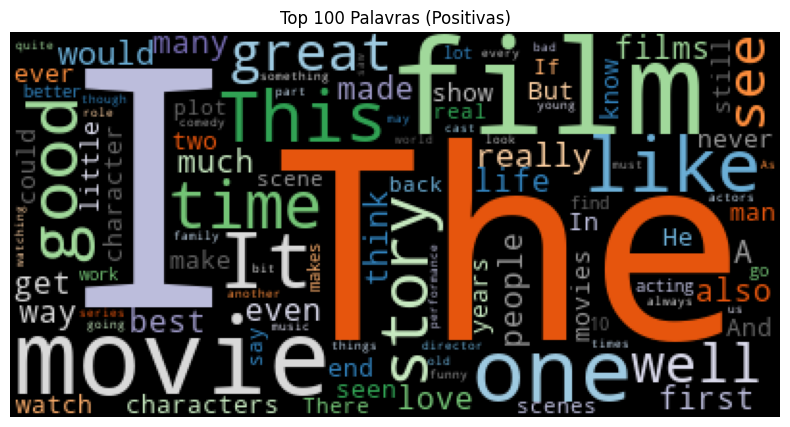

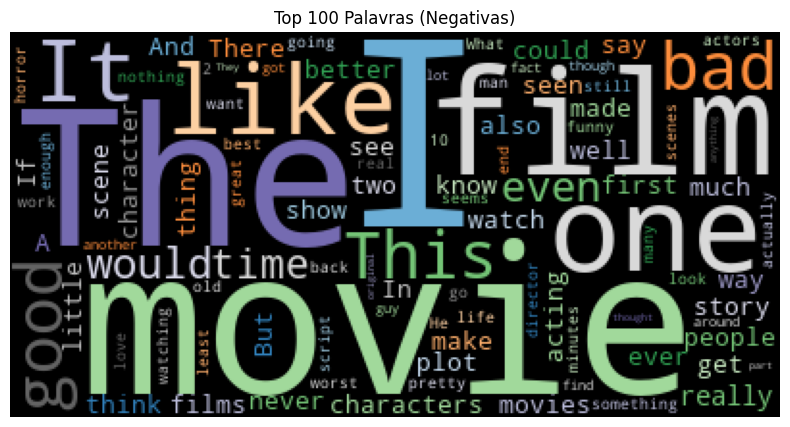

In [198]:
# nuvem de palavras com as 100 palavras mais repetidas durante 
# os reviews classificados como positivos
stop_words = stopwords.words('english')

for word in stop_words:
    freq_positivos.pop(word, None)
    freq_negativos.pop(word, None)

get_word_cloud("Top 100 Palavras (Positivas)", 100, freq_positivos)
get_word_cloud("Top 100 Palavras (Negativas)", 100, freq_negativos)


### Passo 3 - Leitura do Dataset de Sentimentos
---

O objetivo deste passo é ler o CSV referente aos Sentimentos e inserir-los dentro de um novo CSV, desta vez agrupado por emoção ao invés de sentimento. Ou seja, para cada emoção identificada teremos um novo CSV contendo as linhas referentes a emoção, seguindo o formato **[emoção].csv**.

---

In [ ]:
#primeiro lemos o CSV usando a biblioteca pandas para facilitar futuros passos
df_emocoes = pds.read_csv('../assets/NLP/train.txt', delimiter=";", names=["context", "emotion"])
# aqui não é necessário remover tags HTML, pois o dado já vem formatado
emocoes = df_emocoes["emotion"].unique()


for emocao in emocoes:
    path_emocao = "../dist/sentiment/{0}.csv".format(emocao)

    # primeiro nos certificamos de que não existem arquivos no caminho
    # onde vamos escrever os CSV's
    try:
        os.remove(path_emocao)
    except FileNotFoundError as err:
        print("Não existe um CSV para emoção {0}.".format(emocao))
    
    # adquirimos o data frame com a emocao atual
    df_emocao_atual = df_emocoes.loc[df_emocoes['emotion'] == emocao]
    # em seguida escrevemos o CSV dentro do path_emocao
    df_emocao_atual.to_csv(path_emocao, sep=';', encoding='utf-8')
    

### Passo 4 - Sumário dos dados obtidos através da leitura dos Datasets.
---

O objetivo deste passo é apresentar os resultados obtidos após a leitura de cada Dataset e começar com a implementação da nossa rede neural.
Este passo será divido em 2 blocos, sendo o primeiro para o **Dataset de Reviews** e o segundo para o **Dataset de Emoções**.

--- 

### Passo 4.1 - Dataset de Reviews do IMDB.

### Passo 4.2 - Dataset de Emoções.

In [ ]:


valores = df_emocoes['emotion'].value_counts()

print(valores)

traducao = {
    'emotion':'Emoção', 
    'value': 'Incidência',
    'fear': 'Medo',
    'love': 'Amor',
    'anger': 'Raiva',
    'joy': 'Alegria',
    'sadness': 'Tristeza',
    'surprise': 'Surpresa'
}  

fig = px.bar(
    valores, 
    color='value',
    labels=traducao,
    color_continuous_scale=px.colors.sequential.Bluered
)
fig.show()
